# クラスタリング（２）

今回は以下の内容について話す。

- 階層型クラスタリングについて
- DBSCAN について
- 時系列データに対するクラスタリングについて
    - 基本的なコンセプト 
    - 時系列データ間の距離の定義
      - ユークリッド距離
      - Pearson correlation
      - DTW
      - 離散 Wavelet 変換 / 離散 Fourier 変換

## 階層型クラスタリングについて
 
階層型クラスタリングは以前説明したカテゴリの中で言えば "connectivity models" のカテゴリの中に入るものである。
名前の通りクラスタを併合していった順番の階層構造を保持するため、クラスタ数については後から決めることもできる。
 
階層型クラスタリングは他のクラスタリング手法と比べて以下のような利点を持つ。
 
  - （Centroid 系の手法と異なり）クラスタの代表点を計算しづらい状況でも適用可能である。
  - 多数のクラスタに対してスケールする。
  - 同一のクラスタになったデータ点どうしについて、その理由の解釈性が良い。
 
 
欠点としては以下の点があげられる。
 
  - データ点数に対するスケール性において DBSCAN や K-means など多くのアルゴリズムに劣る。
 
 
階層型クラスタリングには、全体を分割していく分割型(divisive)アルゴリズムと、近くにあるデータ点同士を併合していく凝集型の(agglomerative)アルゴリズムとがある。分割型では正確な解を計算しようとすると計算量が肥大化してしまうため、通常は近似アルゴリズムが使われる。
多くの場合使われるのは凝集型であるので、ここでは凝集型のアルゴリズムについて解説する。
 

## 凝集型階層クラスタリングアルゴリズム
 
凝集型階層型クラスタリングアルゴリズムの各手順は以下である。
 
1. 最初に、各データポイントをすべて一つのクラスターであるものとする。したがって、最初のクラスター数はデータポイント数と同じ K である。
0. データ全体の組み合わせの中で最も近くにある2点同士を併合し、 K-1 個のクラスタとする。
0. データ全体の組み合わせの中で最も近くにある2クラスター同士を併合し、 K-2 個のクラスタとする。
0. クラスタが1つになるまで上記のステップを繰り返す。
 
以上のステップを終えるとクラスタがどのように併合されていったかの木構造が得られる。これを適当に決めた閾値または欲しいクラスタ数が得られる閾値まで辿ることによってクラスタが得られる。
この木構造を用いて、樹状図(dendrogram)としてクラスター群を可視化することができる。

ここで注意点として、クラスター間の距離を求めるためにはいくつもの方法がある。いかにいくつか例をあげる:
 
  - single: 2つのクラスタの点で最も近い2点の距離
  - maximum: 2つのクラスタの点で最も離れた2点の距離
  - Ward: クラスタ間距離の増分
  - average: 2つのクラスタのすべての2点の組み合わせに関する距離の平均値

これらのクラスタ間の距離の求め方は階層型クラスタリングの結果に大きく影響を及ぼす。トイデータに対してそれぞれの手法で実行した結果を以下に示そう。

In [6]:
%matplotlib inline
import time # 時間計測用
import warnings # ワーニングメッセージを無視するために使う
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, mixture # クラスタリング用
from sklearn import datasets # データセット作成用
from sklearn.preprocessing import StandardScaler # 正規化に使用するモジュール

# サンプルデータの作成
np.random.seed(0)
n_samples = 1500
random_state = 170

# 1. 二重の円。よく使用されるからか、作成用の専用関数がある。
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
# 2. 2つの弧。これも専用関数がある。
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

# 3. 異なるサイズの3つのクラスタ
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# 4. 3つの楕円。一度クラスタをつくってから、行列を掛けて引き伸ばすことで楕円をつくっている。
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# 5. 3つの円
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# 6. 一様な分布
no_structure = np.random.rand(n_samples, 2), None

In [7]:
# デフォルトのクラスタリングのハイパーパラメータ設定。クラスタ数は3。くっつける点は隣の10個の点のみ。
default_base = {'n_clusters': 3}

# いくつかのクラスタリングについては、設定を以下のように変更する
# 2つの円、2つの弧ではクラスタ数を2に。くっつける点は隣の2個の点のみ
datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {}),
    (aniso, {}),
    (blobs, {}),
    (no_structure, {})]

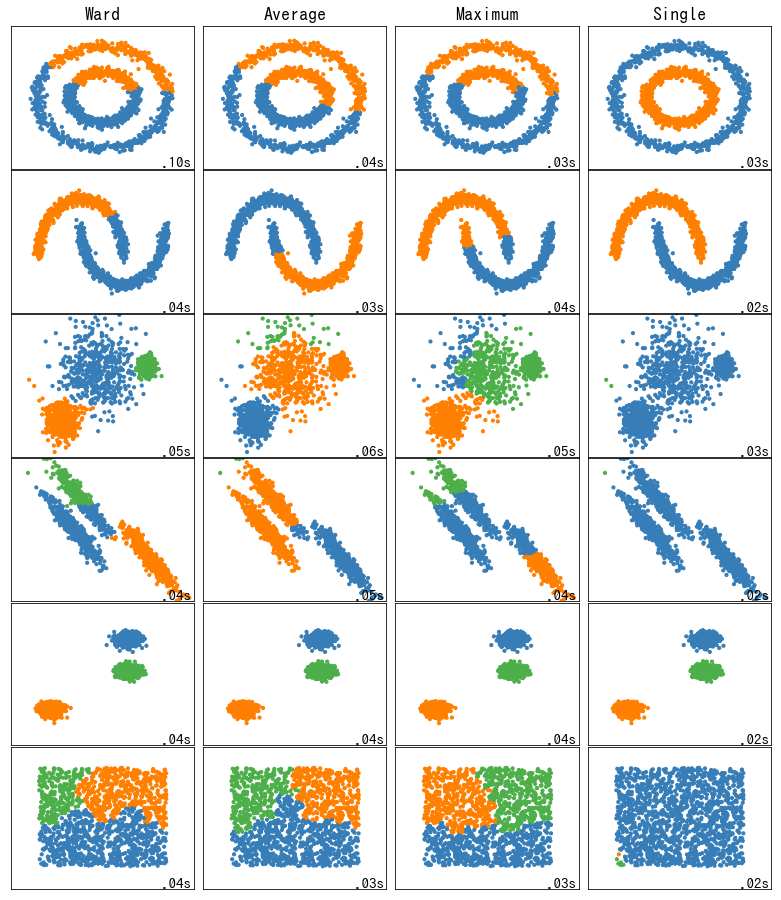

In [8]:
# プロット
plt.figure(figsize=(4 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(datasets): # データセット毎に処理
    # パラメータを設定
    params = default_base.copy()
    params.update(algo_params) # updateメソッドに引数で辞書を入れると、その辞書を用いて辞書を更新できる

    X, y = dataset # データセットを取得
    X = StandardScaler().fit_transform(X)# データセットを正規化

    # 学習
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    average = cluster.AgglomerativeClustering(
        linkage="average",
        n_clusters=params['n_clusters'])
    complete = cluster.AgglomerativeClustering(
        linkage="complete",
        n_clusters=params['n_clusters'])
    single = cluster.AgglomerativeClustering(
        linkage="single",
        n_clusters=params['n_clusters'])
    clustering_algorithms = (
        ('Ward', ward),
        ('Average', average),
        ('Maximum', complete),
        ('Single', single),
    )

    for name, algorithm in clustering_algorithms: # アルゴリズム毎に描画
        t0 = time.time() # 学習所要時間　計測開始

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            # 以下の2つのwarningは無視する
            warnings.filterwarnings("ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings("ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X) # モデルを学習

        t1 = time.time() # 学習所要時間　計測終了

        # モデルによってpredictメソッドが使えないものもあるので、それらについてはlabels_属性を抜き出すことで対応。
        if hasattr(algorithm, 'labels_'): # labels_属性があるものは、それを使う
            y_pred = algorithm.labels_.astype(np.int)
        else: # ないものはpredictメソッドを使う
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0: # 1行目にはタイトルを追加
            plt.title(name, size=18)

        # 色設定
        color_list = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', 
                      '#984ea3', '#999999', '#e41a1c', '#dede00']
        colors = np.array(color_list[:int(max(y_pred)+1)])
        
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5); plt.ylim(-2.5, 2.5)
        plt.xticks(()); plt.yticks(()) # 目盛りを消す
        
        # 学習所要時間を右隅に表示
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
plt.show()

#### 階層型クラスタリングの各ステップ

このセクションでは階層型クラスタリングの動作を実行例の樹形図や散布図を用いた可視化とともに解説する。

以下のようなデータをトイデータとして用いる。

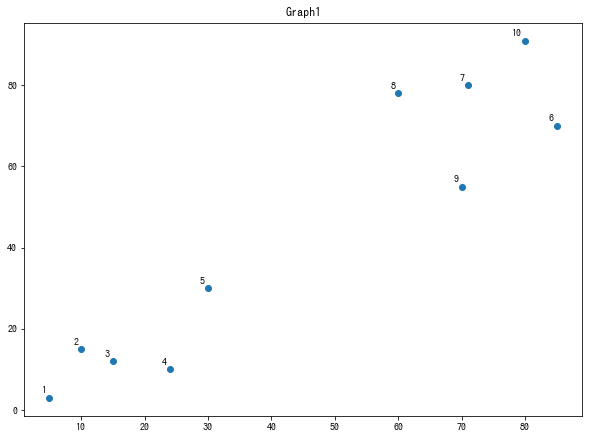

In [9]:
# トイデータの準備とその散布図による可視化
import numpy as np

# トイデータの定義
X = np.array([[5,3],[10,15],[15,12],[24,10],[30,30],[85,70],[71,80],
    [60,78],[70,55],[80,91],])

import matplotlib.pyplot as plt

# 散布図による可視化
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(X[:,0],X[:,1], label='True Position')

# ラベルを付加
labels = range(1, 11)
for label, x, y in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.title("Graph1")
plt.show()

これらのデータ点群が2つのクラスタを形成していることが見て取れる。左下の点1-5でできているものと、右上の点6-10のものだ。

ここに階層的クラスタリングを適用し、樹形図を描く。  
sklearnから樹形図を書くのは面倒(自作関数をつくる必要あり)なので、ここではscipyを使用する。

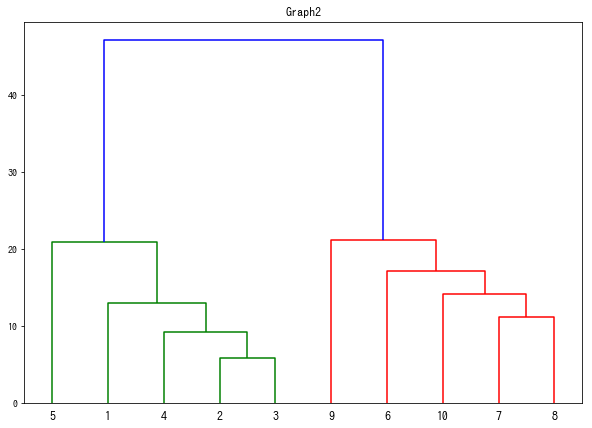

In [10]:
# クラスタリングと樹形図による可視化
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# 樹形図のための階層型クラスタリングを実行。scipyを使うと1行で書ける。
#   - 点同士の距離はユークリッド距離に基づく
#   - クラスタ同士の距離は最も近い点同士の距離とする
linked = linkage(X, 'single')

# 樹形図をプロット
labelList = range(1, 11)
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending',
            show_leaf_counts=True)
plt.title("Graph2")
plt.show()

Graph2の樹状図では下から順にたどることでクラスタの併合の順序がわかる。水平の線は2つのクラスタが併合されていることを示しており、その位置は併合された2クラスタ間の距離を示している。
この樹状図に従ってアルゴリズムの動作を順を追って説明する。まず最初に、ユークリッド距離で最も近い2点同士を見つける。点2と3、点7と8がそれぞれ近いことがグラフからわかる。従って、これらの2点でまずクラスタが形成される。樹状図でもこれらの2点がつながっていることがわかり、また点7と8との間の距離は点2と3との間の距離より大きいことも読み取れる。

次のステップではこれらのクラスタの中で近いもの同士を併合することになる。Graph1から、点4が点2と3のクラスタに近いことがわかる。従って点2と3のクラスタに点4がつながる。このプロセスを一つの大きなクラスタができるまで繰り返す。

一度大きな1つのクラスターが形成されると、次に分割の閾値となる距離を定める。閾値の値を赤い水平の線で示す。例えば以下の図のように引いてみよう:

<img src="https://s3.amazonaws.com/stackabuse/media/hierarchical-clustering-python-scikit-learn-3.png"/>

赤の線と交差する線の数が2本あり、これはクラスタ数が2つであることを示している。

閾値をここからさらに下げていくと以下のようになる:

<img src="https://s3.amazonaws.com/stackabuse/media/hierarchical-clustering-python-scikit-learn-4.png"/>

上のプロットでは4本の垂直の線が閾値を示す水平の線を横切っており、4つのクラスタができることがわかる。つまり点6,7,8,10からなるクラスター、点3,2,4からなるクラスター、そして点9と5とは一点のみから形成されるクラスタとみなされる。

クラスタの数が事前に判断しづらい場合、樹状図による可視化を一度行うことでクラスタの併合状況から適切な閾値について判断できるかもしれない。

## DBSCAN (Density-Based Spatial Clustering of Application with Noise)

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) は密度の高い点群をクラスターとして切り出す手法である。DBSCAN には様々な分布の形状に対して、それが密度の高い領域であれば検出可能であるという利点がある。

DBSCAN においてクラスターは以下のように定義される。近傍とみなす距離 eps とクラスタとみなす点の数 min_pts をパラメータとして与える。

1. データセット内の各点に対して距離が eps 以下の近傍を探索し、存在するデータ点の数をカウントする。
0. 1.で存在したデータ点の数によりデータ点を次の3種類に分類する。

  - Core: min_pts 以上の数の点が近傍に存在する。
  - Border: 近傍に存在する点の数は min_pts 以下だが、Core 点の近傍に存在する点
  - Noise: Core 点が近傍に存在しない点
  
0. 上記の分類に基づき、ある Core 点の近傍にある点はその Core 点と同一のクラスタになるようにクラスタを形成する。

図にすると下のようになる:

<img src="https://miro.medium.com/max/2000/1*zbm_3K647rvNDmgL6HWUNQ.png"/>

実際に上記の定義に従ってクラスターを形成する際、DBSCAN はまずランダムに開始点を選ぶ。そして、近傍の点の数を計算してその点がCore点かどうかを計算し、Core 点であり近傍に点が存在した場合は近傍をたどってクラスターとなる点を探索していく。それ以上クラスターが拡張できなくなった時、次のクラスタを探索していく。

上の図において青色で示されているような Noise 点の存在が許容されているように、DBSCAN は全てのデータ点を分類する必要がない。そのため、DBSCAN は外れ値の取り扱いにおいて威力を発揮する。

また、上の図では便宜上平面上に散らばった点のユークリッド距離に基づいた説明を行なっているが、DBSCANでは距離の定義として任意の指標を用いることができ、一定以下の距離の点を「近傍に存在する」ものとみなしてクラスタリングを行うことが可能である。


DBSCANの利点は以下である:
- データ点の密度が高いクラスターを切り出すことができる。
- 外れ値の影響を受けづらい。

DBSCANの欠点は以下である:
- 密度にバラつきがあるときでないとうまく動作しない。 同じような密度の領域が連続しているとき、それらをクラスタに区分することは難しいだろう。
- 距離指標を適切に定義する必要がある。
- 例えば高次元データに対してはユークリッド距離を用いてもあまりうまく動作することが期待しづらいだろう。

ここから、テストデータに対してのDBSCANの実行例を示そう。

In [11]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# サンプルデータを作成
centers = [[1, 1], [-1, -1], [1, -1]] # 重心
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0) # 重心をもとに、標準偏差0.4のクラスタをつくる。
# データを正規化
X = StandardScaler().fit_transform(X)

# モデリング
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

# コアか否かをTrue/Falseで格納するnp.arrayを作成
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# クラスタリング結果をlabels_属性から取得
labels = db.labels_ 

# ノイズを除くクラスタ数を計算
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 18


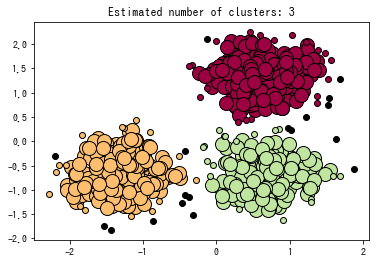

In [12]:
import matplotlib.pyplot as plt

unique_labels = set(labels)
# ラベル毎に色を設定。
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1: # ノイズの場合は、クラスタ結果が-1となる。
        # ノイズの場合は色は黒を使う。
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    # コア
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    # 非コア
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

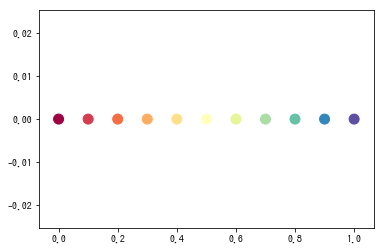

In [13]:
x = np.linspace(0,1,11) # 0, 0.1, ..., 1。11個。
y = np.zeros(11) # 0, 0, ..., 0。11個。
colors = [plt.cm.Spectral(each) for each in x]

plt.scatter(x, y, c=colors, s=100)

# 時系列クラスタリングについて

ここまでの議論では、各データ点同士の順序関係にほとんど意味がない状況を前提としていた。つまり、表などに並べる際にもその順番は便宜上のものであり、シャッフルしても本質的にデータの内容に影響をあたえないような状況である。

もちろんそういったデータを扱う状況も多いが、CANデータなどはこの状況には合致しないといえるだろう。時間の経過に従って順番に観測したデータである以上順番を変えてしまっては全くその意味するところが異なってしまうし、各時点の意味するところもその前後関係の中で捉えたいことは多いだろう。このように順番が意味を持つデータを系列データと呼び、その中でも特に時間に沿って並んだデータを時系列データと呼ぶ。
ここではそういった系列データに対するクラスタリングについて考えよう。


### 基本的な考え方

ここまで見てきたように、クラスタリングとは__データ点群をそれらの間の類似性に従っていくつかのグループにまとめる__ 処理を指すが、系列データに対して問題を捉えなおすのであれば、__系列中での区間同士をそれらの類似性に従っていくつかのグループにまとめる__処理を行うことであるということになるだろう。

以下の図は時系列クラスタリングの実行例である（[Pjotr Roelofsen, 2018](https://beta.vu.nl/nl/Images/stageverslag-roelofsen_tcm235-882304.pdf) より）。

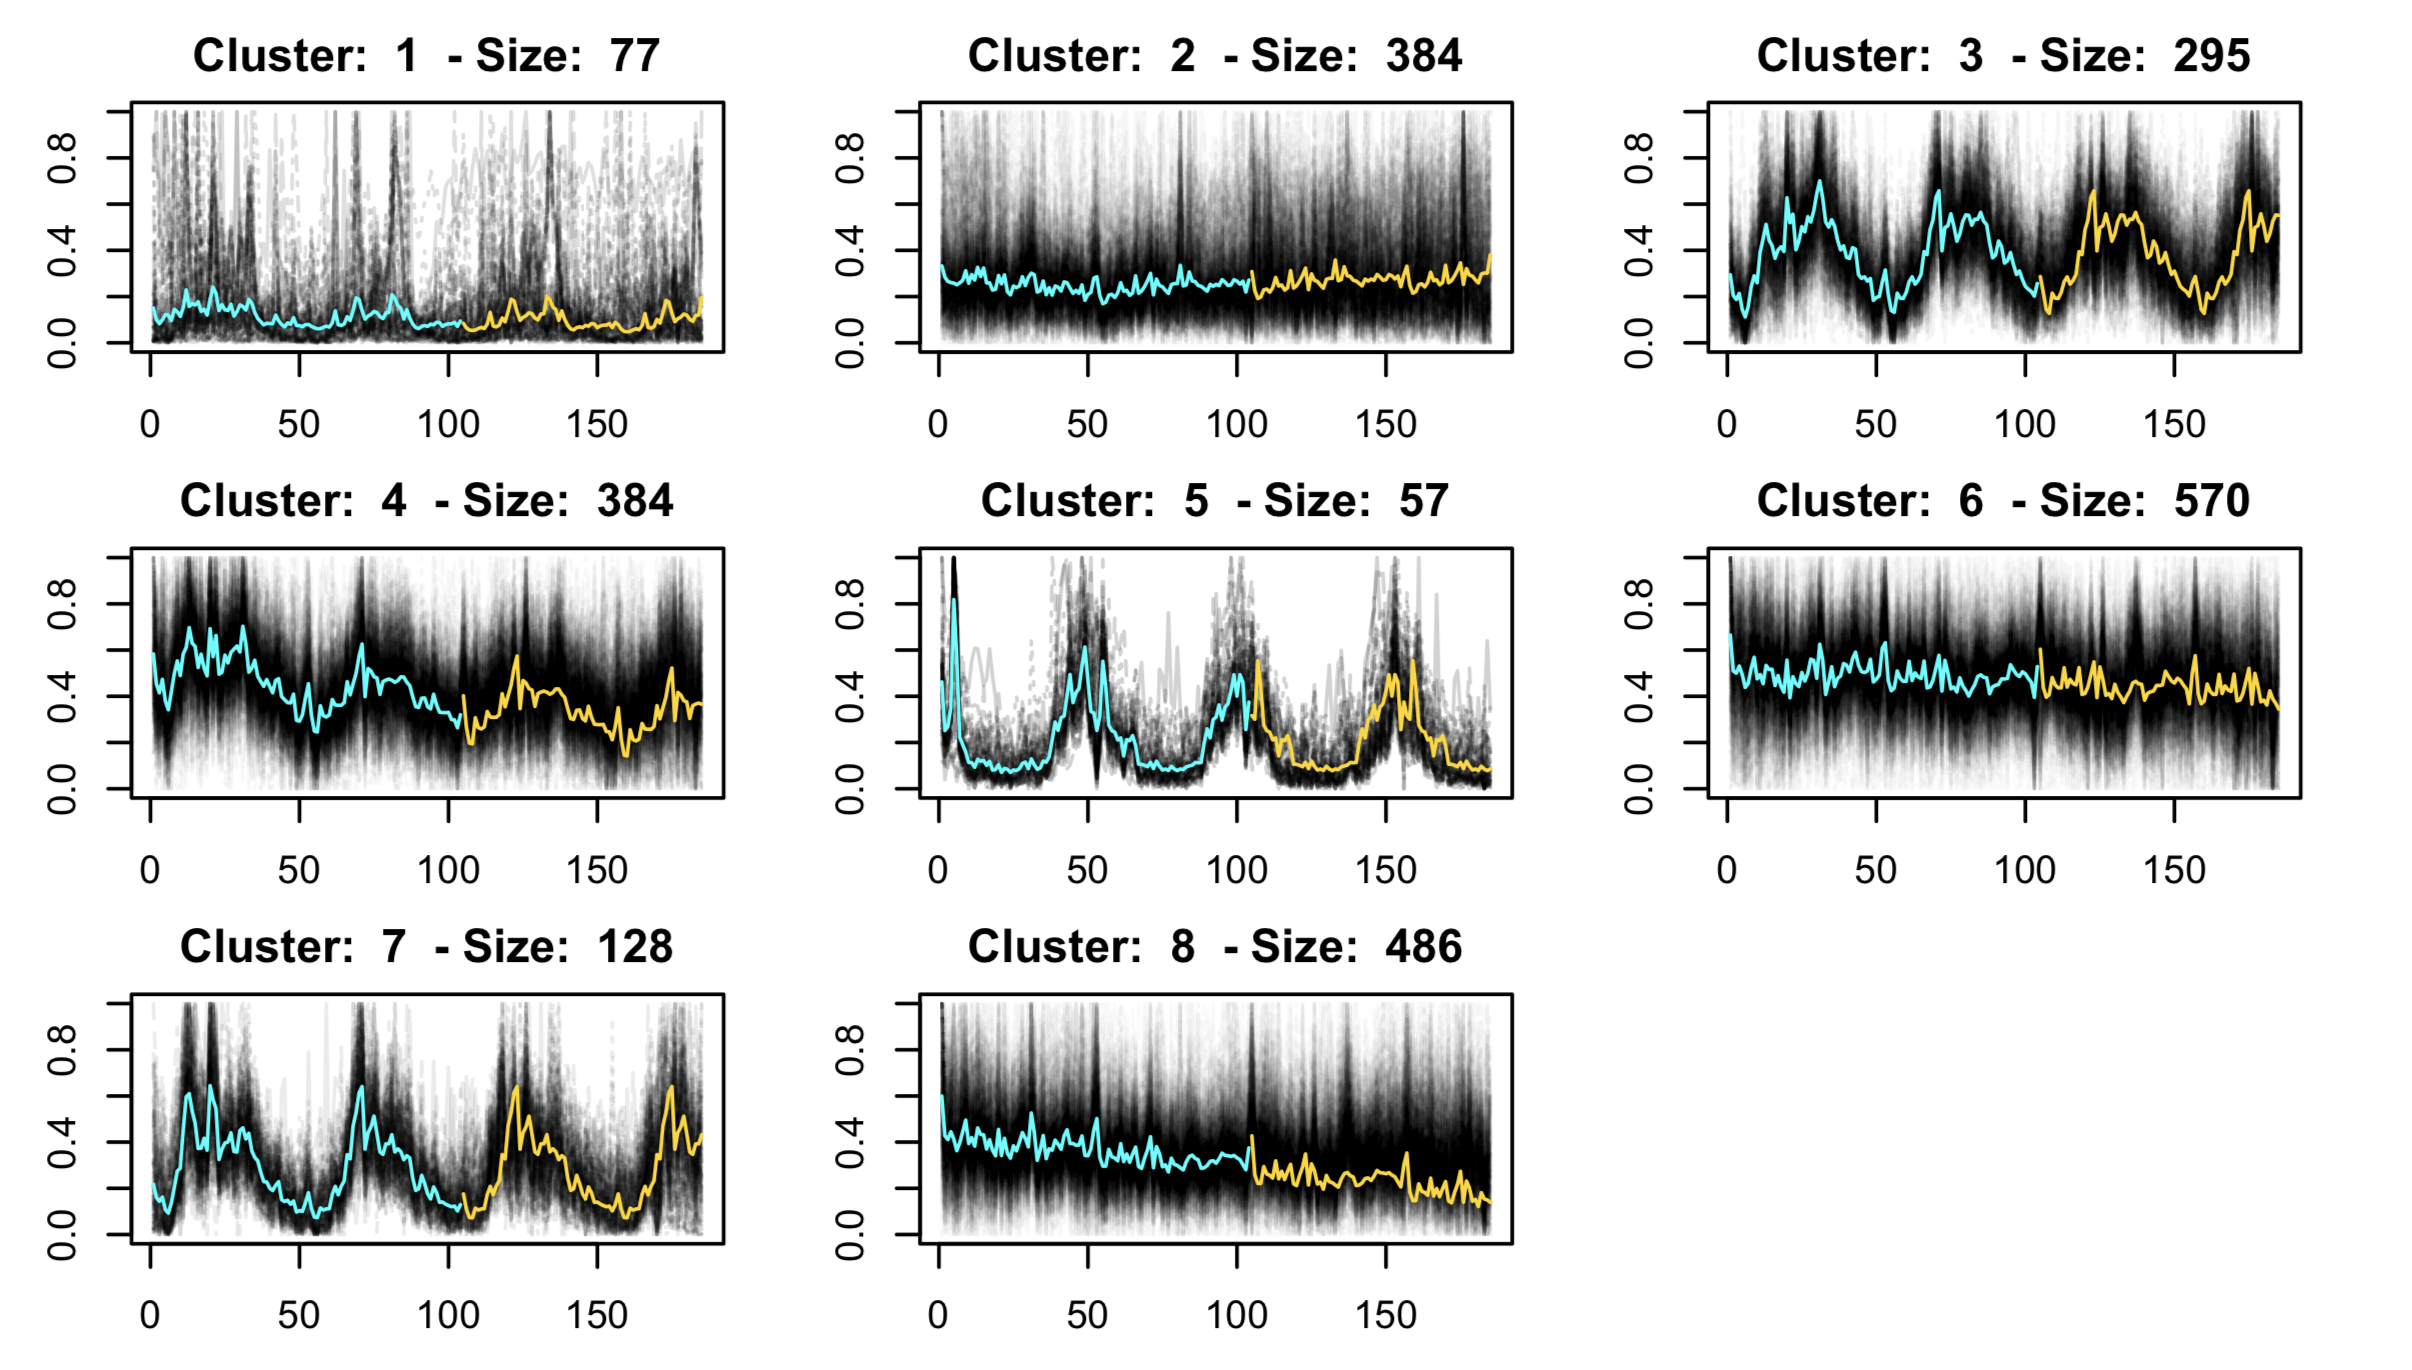

In [1]:
from IPython.display import Image
Image("./ts-clustering-example.png")

これまで見てきたように、階層型クラスタリングやDBSCANなど、クラスタリング手法の中にはデータ点同士の__距離__さえ定義されていればクラスタ計算を実行できるアルゴリズムがある。ということは、__系列中での各区間同士に対して距離を定義する__ことさえできれば系列に対してクラスタリングを実行することができる。

そのように系列データ同士の距離を定義する方法についていくつかの手法が提案されているので、これにより系列データの区間同士に対して距離を計算し、クラスタリングを実行することができる。

以下に、ここまでに述べた時系列クラスタリングの基本的な考え方を図示する。

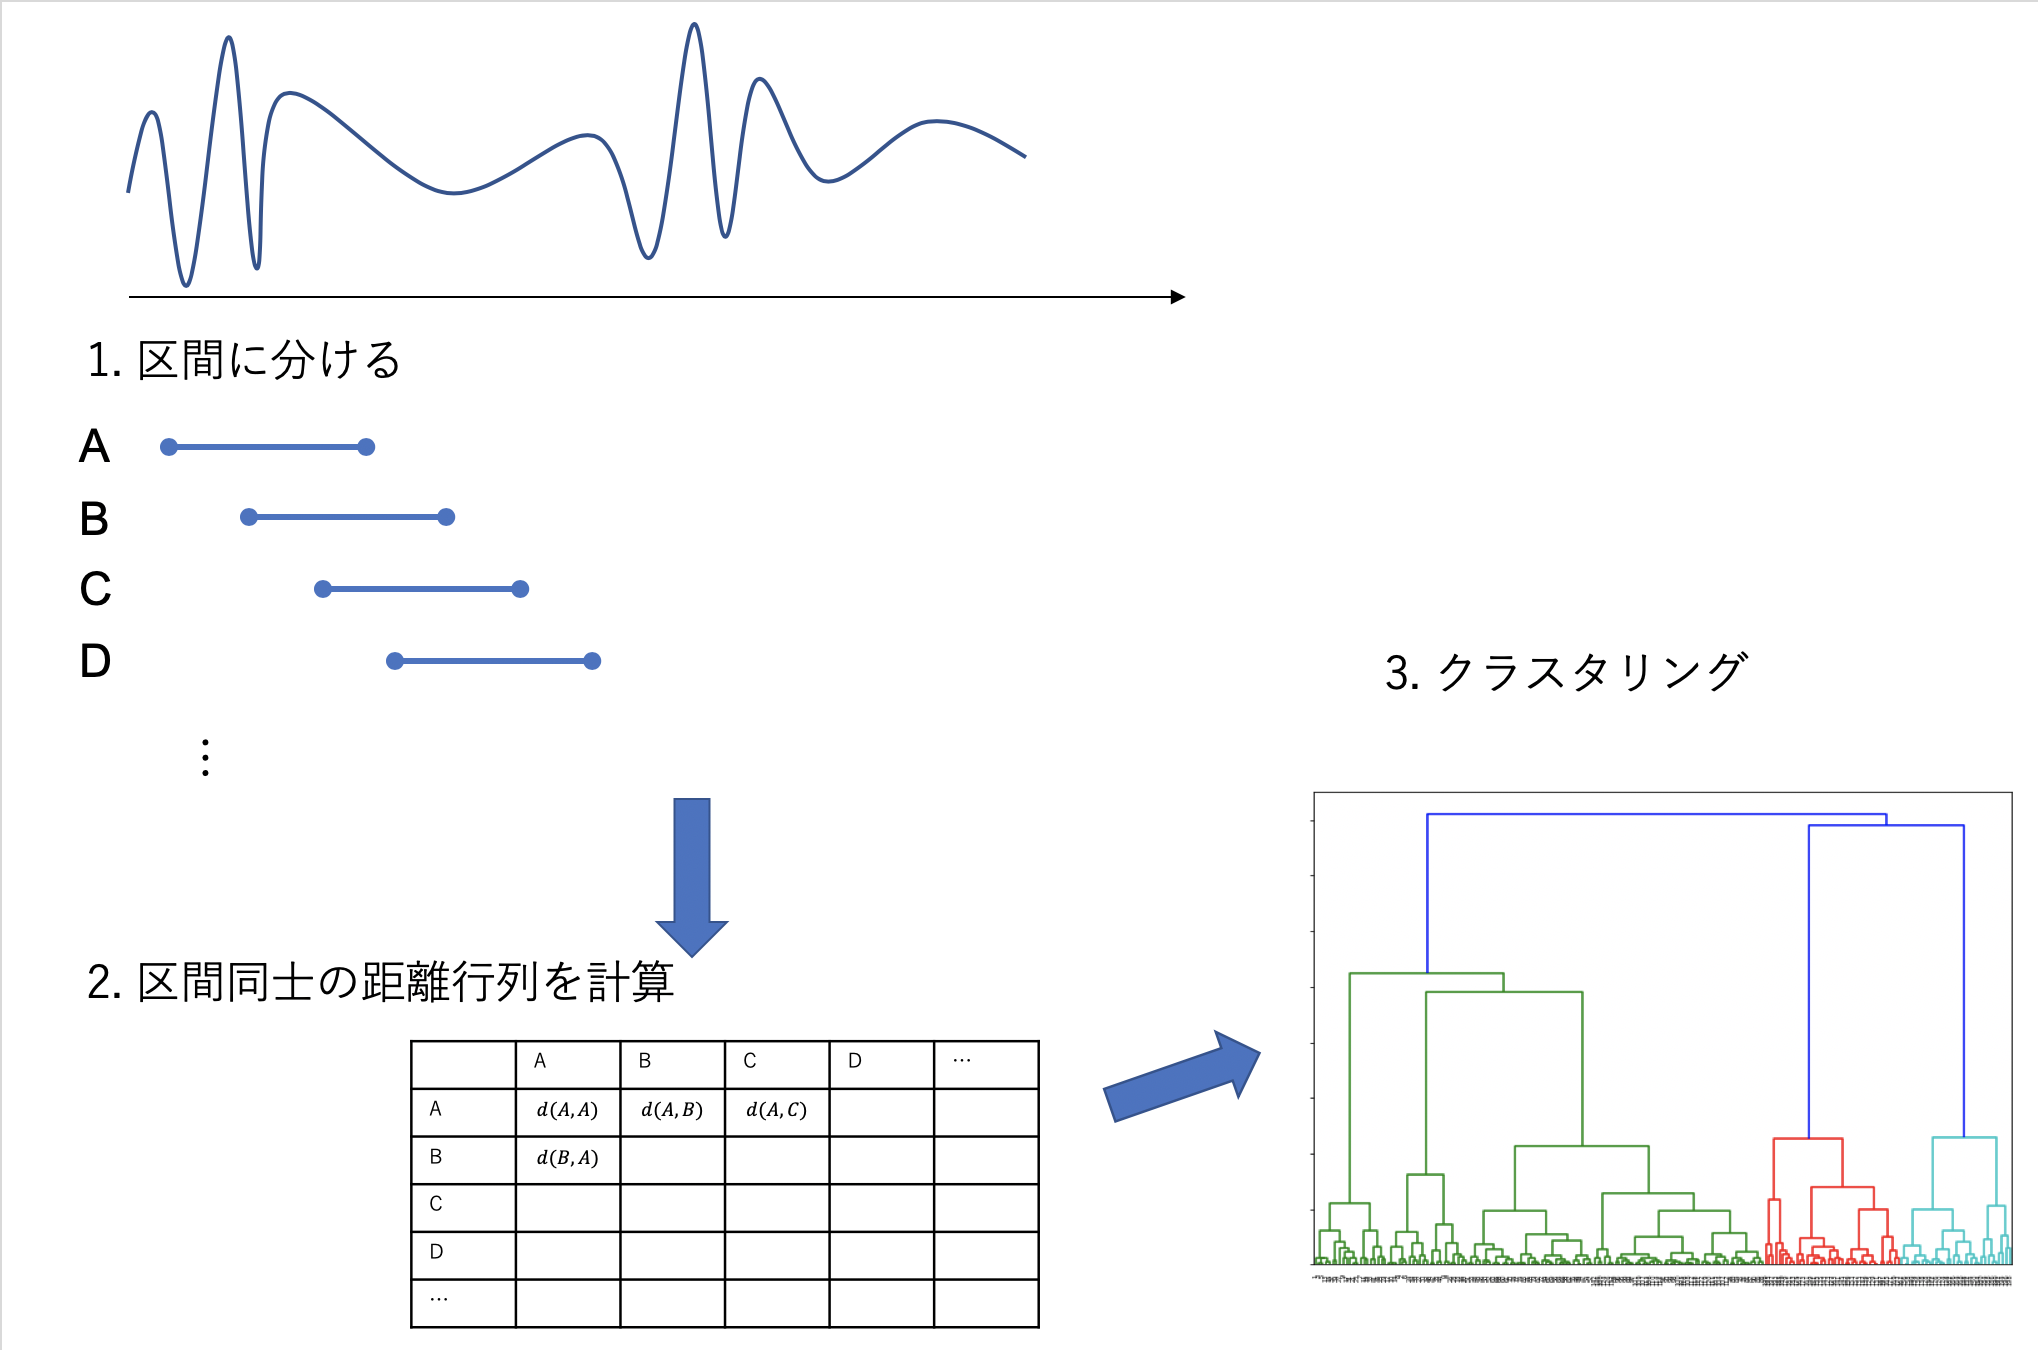

In [2]:
Image("./ts-clustering-basic.png")

系列内の区間に切って行く際の長さは捉えたい系列状のパターンを捉えられる程度に広い幅で設定する必要があるだろう。

次の項では距離計算手法について見ていこう。

### 距離の定義

以下でいくつかの距離の定義に触れる。

距離を計算したい系列内の区間をベクター$\mathrm{x}$、$\mathrm{y}$と書く。

#### ユークリッド距離

最もシンプルなアイデアとしては$\mathrm{x}$、$\mathrm{y}$同士のユークリッド距離を系列同士の距離とすることだろう:

$$
d(\mathrm{x}, \mathrm{y})=(\sum_i{|x_i-y_i|^2})^\frac{1}{2}
$$

似た指標として以下に定義されるマンハッタン距離が使われることもある:

$$
d(\mathrm{x}, \mathrm{y})=\sum_i{|x_i-y_i|}
$$

#### Pearson 相関係数

2つのベクターの類似度を考えるとき、相関係数を使うことも自然な発想として考えられるだろう。Pearson の相関係数$\rho (\mathrm{x}, \mathrm{y})$を用いて以下のように距離を定義することができる:

$$
d(\mathrm{x}, \mathrm{y})=1-\rho (\mathrm{x}, \mathrm{y})
$$


これらの手法はシンプルだが、ノイズが少ない状況であり系列上のズレなどが小さければ効果を発揮するだろう。計算量的にも非常に高速である。

#### Dynamic Time Warping

上記の2つの手法では2つの系列はあくまで一種の対として扱われていただけである。つまり、ある系列上のデータ点 $x_i$ は比較対象となる系列の中の同一の点 $y_i$ と突き合わせて計算されていた。これは系列的な前後関係をあまり考慮していないと言える。その結果生じる問題として、系列上の伸び縮みやちょっとしたズレがあった場合にも距離が大きくなりがちである。

そういった問題を避けるため、系列中のある点を比較対象の系列のデータ点全体との関係の中で利用して類似度を計算できるように考えられた手法が Dynamic Time Warping である。下の図を用いてアイデアを説明しよう。

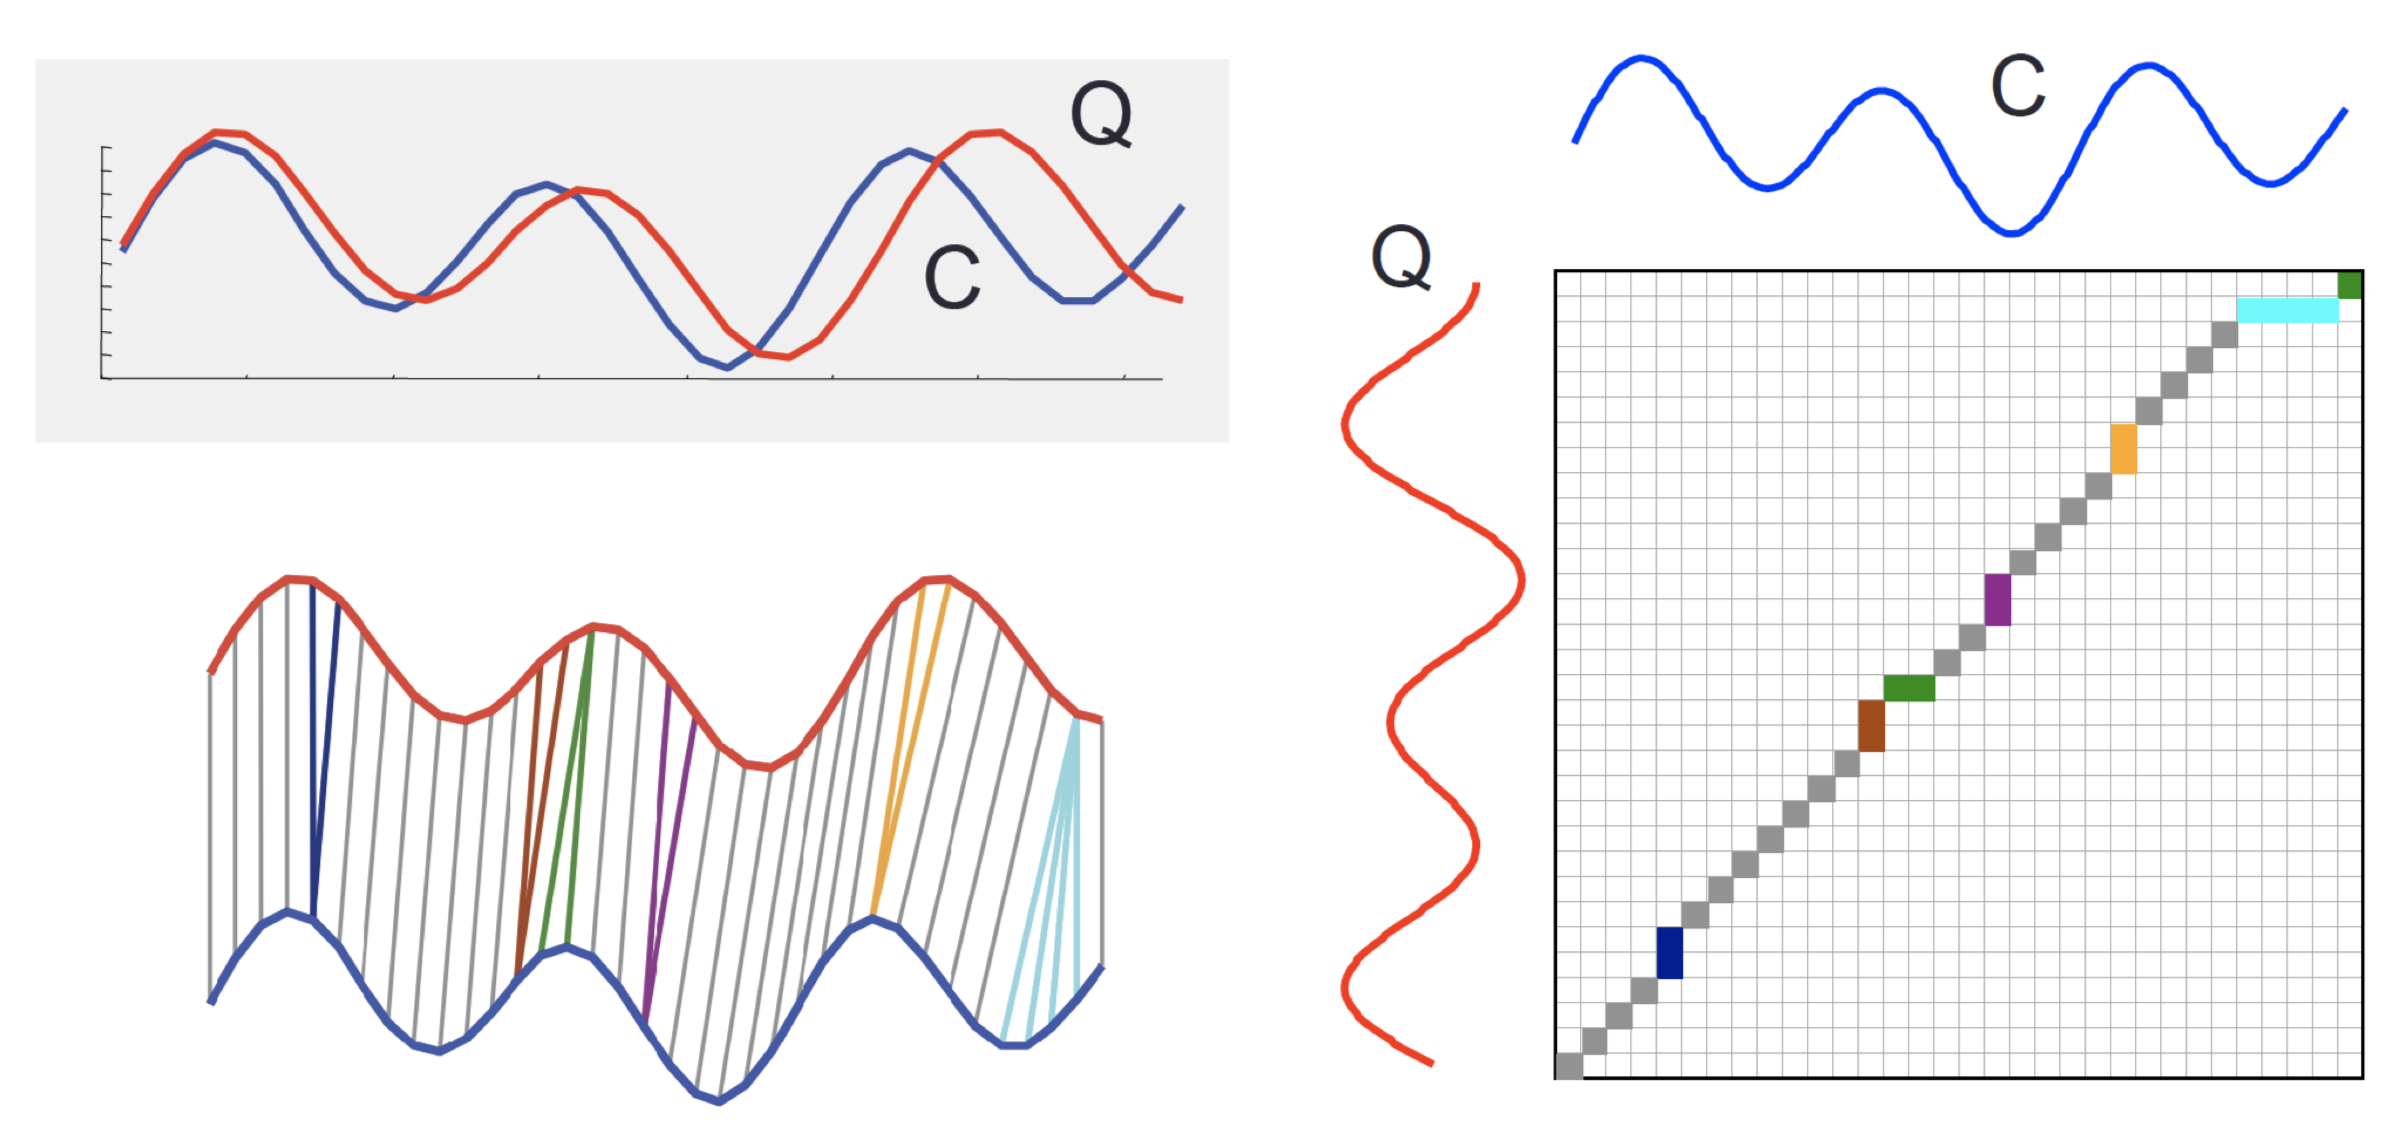

In [3]:
Image("./DTW.png")

ここで、QとCという2つの系列を比較することを考える（重ね合わせて描くと左上の図になる）。

左下の図では、2つの系列中のデータ点同士で対応関係にあるとみなされた点同士を線で結んでいる。色がついている直線はデータ点の対応関係が多対一になっている部分である。これは系列上の「伸び縮み」があった場所であるととらえて良い。例えば、曲線Cの一つ目の谷は曲線Qの谷よりも系列の中で「早く」発生している。青の線によって系列Cの点が系列Qの点のうちの2箇所と連結されている箇所はこの系列中の位置を補正している。

右下の行列は実際に計算する場合の手順を説明したものである。各マスには系列が各マスに対応するデータ点までであった場合の途中計算の結果が入る。計算方法については後でより詳しく述べるが、何らかの色がついているマスが実際の計算の際に採用されたマスで、DTW距離を最小化するような系列の伸び縮みの関係を記述した経路（minimum warping path）をたどることができる。

より厳密に DTW 距離がどのように計算されるかを述べると、以下のようになる。

$$
d_{cum}(i, j) = d(x_i, y_j ) + min \{ d_{cum}(i − 1, j − 1), d_{cum}(i − 1, j), d_{cum}(i, j − 1)\}
$$

ここで$d(x_i, y_j )$はユークリッド距離など適当な距離指標である。
これを$i$, $j$について順番に計算し、両方が系列の長さに至ったときの値が DTW 距離である。

この式による記法を踏まえて先の図に注釈を加えると以下のようになる。

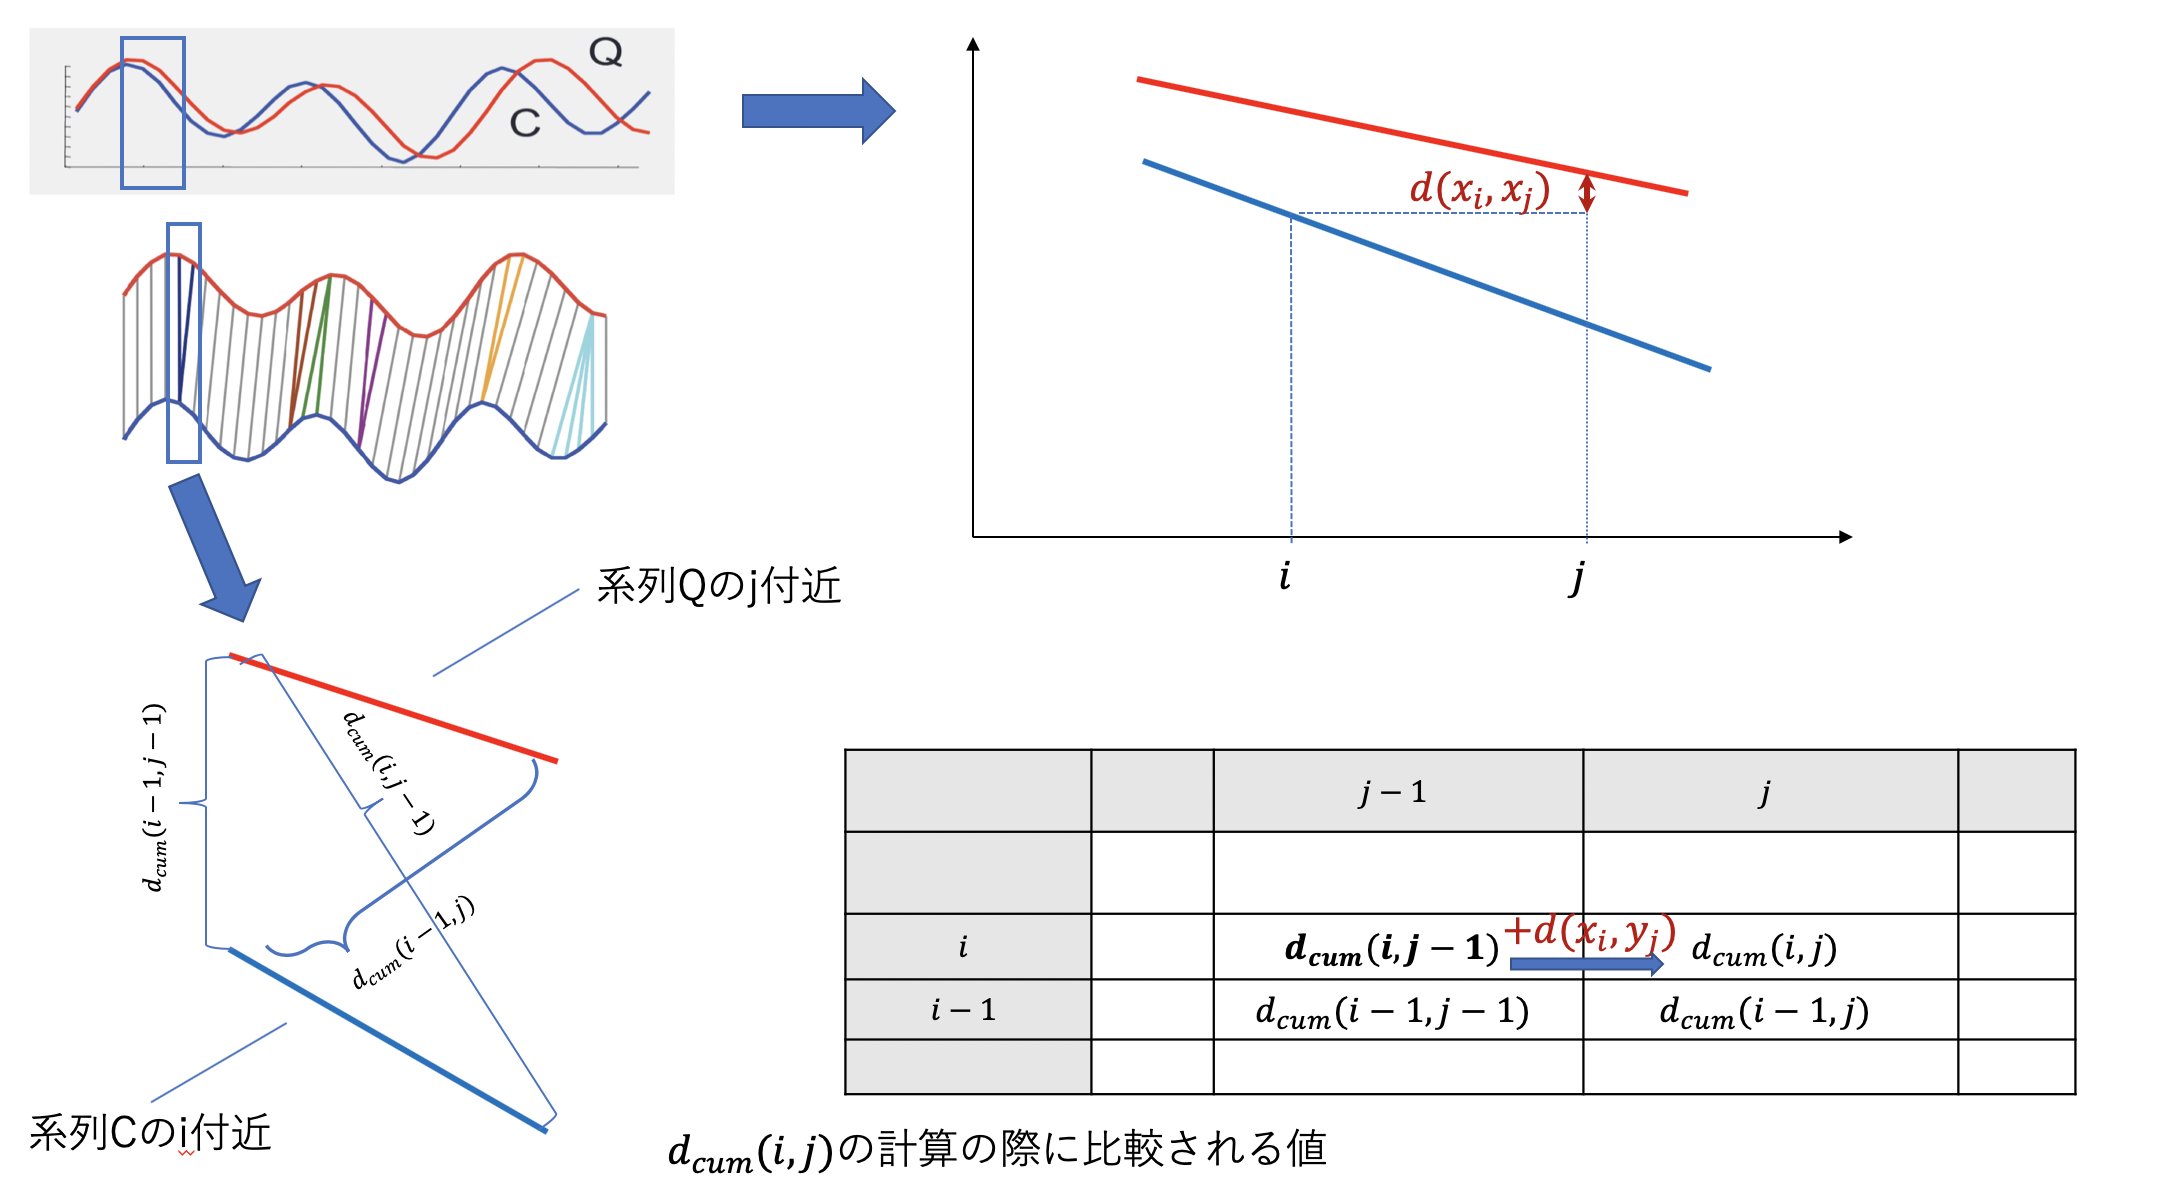

In [4]:
Image("./DTW2.png")

このような計算を行列全体に広げることでDTW距離が得られる。

### 次元削減

系列データのクラスタリングにおいて、上記の距離を計算する区間の長さはある程度の長さを持たせた方が多く情報を使えると考えられる。
しかし一方で長さが長くなるということは問題の次元を増やすということになり、計算上の難しさが増してしまう。そこで前回解説したような次元削減を行うことを考えたい。ただし、通常の表データを対象とするような次元削減手法は系列データには不向きであるため、系列データを対象として利用可能な次元削減手法を以下に紹介しよう。

#### 離散フーリエ変換・離散ウェーブレット変換

フーリエ変換およびウェーブレット変換は系列データを関数の重ね合わせに変換する手法である。三角関数の重ね合わせに変換するものがフーリエ変換で、ウェーブレットと呼ばれる関数の重ね合わせに変換するものがウェーブレット変換である。

これらの手法について数学的な詳細は述べないが、時系列データにおける次元削減とどのように関係するのかについてだけ述べておく。基本的な考え方として、時系列の現象を捉えるとき、捉えたい変動のタイムスケールよりもずっと短い周期で起きる（≒高周波数の）変動はノイズとして無視しても良いと考えられる。フーリエ変換やウェーブレット変換を用いることで高周波数のデータの変動とより意味を持つ周波数帯で起きる変動とを分離し、ノイズ周波数帯を無視することで本質的な情報を損なわないまま系列データを表現する次元の数を減らすことができる。

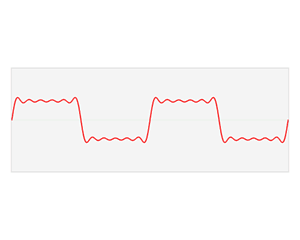

In [5]:
Image("./Fourier_transform_time_and_frequency_domains_(small).gif")

### 参考文献

[Pjotr Roelofsen, 2018](https://beta.vu.nl/nl/Images/stageverslag-roelofsen_tcm235-882304.pdf)